In [1]:
import numpy as np
import matplotlib
matplotlib.rc('image', cmap='gray')
import matplotlib.pyplot as plt
plt.rcParams['figure.dpi'] = 140
import cv2
from scipy.ndimage.filters import gaussian_filter1d
from scipy.optimize import minimize, Bounds

In [2]:
def find_basin_mins(img):
    img = img - img.min()
    img = img / img.max()
    im = np.ones((img.shape[0]+2, img.shape[1]+2))
    im[1:-1, 1:-1] = img
    visited = np.ones(im.shape)
    visited[1:-2, 1:-2] = 0

    min_img = np.zeros(im.shape)
    basin_mins = []

    for i, j in np.ndindex(im.shape):
        if visited[i, j]:
            continue
        cur = im[i, j]
        bfs_queue = {(i, j)}
        bfs_seen = set()
        mark = None
        while bfs_queue:
            r, c = bfs_queue.pop()
            neighbors = [(r-1, c), (r+1, c), (r, c-1), (r, c+1)]
            for r_n, c_n in neighbors:
                if im[r_n, c_n] == cur:
                    if visited[r_n, c_n]:
                        mark = min_img[r_n, c_n]
                    elif (r_n, c_n) not in bfs_seen:
                        bfs_queue.add((r_n, c_n))
                elif im[r_n, c_n] < cur:
                    mark = 0
            bfs_seen.add((r, c))
            if mark is not None:
                break
        if mark is None:
            mark = 1
            i_min, j_min = next(iter(bfs_seen))
            basin_mins.append((i_min-1, j_min-1))
        for r, c in bfs_seen.union(bfs_queue):
            min_img[r, c] = mark
            visited[r, c] = 1

    return min_img[1:-1, 1:-1], basin_mins

In [3]:
import sympy as sp

X, Y, x, y, A, sx, sy, theta = sp.symbols('X Y x_0 y_0 A sigma_x sigma_y theta')
syms = [X, Y, x, y, A, sx, sy, theta]
a = sp.cos(theta)**2/(2*sx**2) + sp.sin(theta)**2/(2*sy**2)
b = -sp.sin(2*theta)/(4*sx**2) + sp.sin(2*theta)/(4*sy**2)
c = sp.sin(theta)**2/(2*sx**2) + sp.cos(theta)**2/(2*sy**2)
gauss = A*sp.exp(-(a*(X-x)**2 + 2*b*(X-x)*(Y-y) + c*(Y-y)**2))
dg_dA = sp.lambdify(syms, sp.diff(gauss, A), 'numpy')
dg_dsx = sp.lambdify(syms, sp.diff(gauss, sx), 'numpy')
dg_dsy = sp.lambdify(syms, sp.diff(gauss, sy), 'numpy')
dg_dtheta = sp.lambdify(syms, sp.diff(gauss, theta), 'numpy')
gauss = sp.lambdify(syms, gauss, 'numpy')

dg_dA



<function _lambdifygenerated(X, Y, x_0, y_0, A, sigma_x, sigma_y, theta)>

In [4]:
def to_coord(mins, sz):
    coords = []
    for r, c in mins:
        x = c - sz/2
        y = r - sz/2 - 1
        coords.append([x, y])
    return np.array(coords)        

In [6]:
import sympy as sp

# def gauss(X, Y, x, y, A, sigma_X, sigma_Y, theta):
#     a = np.cos(theta)**2/(2*sigma_X**2) + np.sin(theta)**2/(2*sigma_Y**2)
#     b = -np.sin(2*theta)/(4*sigma_X**2) + np.sin(2*theta)/(4*sigma_Y**2)
#     c = np.sin(theta)**2/(2*sigma_X**2) + np.cos(theta)**2/(2*sigma_Y**2)
#     return A*np.exp(-(a*(X-x)**2 + 2*b*(X-x)*(Y-y) + c*(Y-y)**2))

X, Y, x, y, A, sx, sy, theta = sp.symbols('X Y x_0 y_0 A sigma_x sigma_y theta')
syms = [X, Y, x, y, A, sx, sy, theta]
a = sp.cos(theta)**2/(2*sx**2) + sp.sin(theta)**2/(2*sy**2)
b = -sp.sin(2*theta)/(4*sx**2) + sp.sin(2*theta)/(4*sy**2)
c = sp.sin(theta)**2/(2*sx**2) + sp.cos(theta)**2/(2*sy**2)
gauss = A*sp.exp(-(a*(X-x)**2 + 2*b*(X-x)*(Y-y) + c*(Y-y)**2))
dg_dA = sp.lambdify(syms, sp.diff(gauss, A), 'numpy')
dg_dsx = sp.lambdify(syms, sp.diff(gauss, sx), 'numpy')
dg_dsy = sp.lambdify(syms, sp.diff(gauss, sy), 'numpy')
dg_dtheta = sp.lambdify(syms, sp.diff(gauss, theta), 'numpy')
gauss = sp.lambdify(syms, gauss, 'numpy')

def gmm(params, mins, sz):
    domain = np.linspace(-sz/2, sz/2-1, sz)
    X, Y = np.meshgrid(domain, domain)
    f = np.zeros(X.shape)
    for x, y in mins:
        f += gauss(X, Y, x, y, *params[:4])
        params = params[4:]
    return f

def gmm_grad(params, mins, sz):
    domain = np.linspace(-sz/2, sz/2-1, sz)
    X, Y = np.meshgrid(domain, domain)
    grads = []
    for x, y in mins:
        args  = np.concatenate([[X, Y, x, y], params[:4]])
        grads += [dg_dA(*args), dg_dsx(*args), dg_dsy(*args), dg_dtheta(*args)]
        params = params[4:]
    return np.array(grads)
    
# not accounting for filt
def loss(params, mins, label, filt):
    sz = label.shape[0]
    f = gmm(params, mins, sz)
    loss_img = (f-label)**2
    return np.sum(loss_img)

def loss_grad(params, mins, label, filt):
    sz = label.shape[0]
    f = gmm(params, mins, sz)
    return np.sum(2*(f-label) * gmm_grad(params, mins, sz), axis=(1,2))

In [24]:
for frame_num in range(12, 13):
    orig = cv2.imread("test_images/tracer/{}.png".format(frame_num),
                      cv2.IMREAD_GRAYSCALE)
#     orig = cv2.imread("gaussians.png", cv2.IMREAD_GRAYSCALE)
    orig = orig[50:825, 125:900]
    orig = cv2.resize(orig, (300, 300))
    im = cv2.GaussianBlur(orig, (5, 5), 0)
    im = im - im.min()
    im = im / im.max()

    min_img, mins = find_basin_mins(-im)
    mins = to_coord(mins, im.shape[0])
    params = np.array([1, 15, 15, 0]*len(mins))
    filt = get_concave_map(-im)
    bound = Bounds([.01, 2, 2, -2*np.pi]*len(mins),
                    [np.inf, 20, 20, 2*np.pi]*len(mins))
    res = minimize(loss, params, bounds=bound, args=(mins, im, filt),
                   method='L-BFGS-B', jac=loss_grad, options={'gtol': 1e-1})

In [15]:
def get_concave_map(im, thresh=0):
    result = np.zeros(im.shape)

    ygrad, xgrad = np.gradient(im)
    ygrad = ygrad - ygrad.min()
    xgrad = xgrad - xgrad.min()
    yygrad, yxgrad = np.gradient(ygrad)
    xygrad, xxgrad = np.gradient(xgrad)
    hessians = np.array([[yygrad, yxgrad],
                         [xygrad, xxgrad]])

    for i, j in np.ndindex(im.shape):
        hessian = hessians[:, :, i, j]
        eigvals = np.linalg.eigvals(hessian)
        is_max = np.all(eigvals > 0)
        total = sum(eigvals)
        result[i, j] = 1 if total>0.01 else 0
#         if is_max:
#             if total < thresh:
#                 result[i, j] = abs(total)
    return result

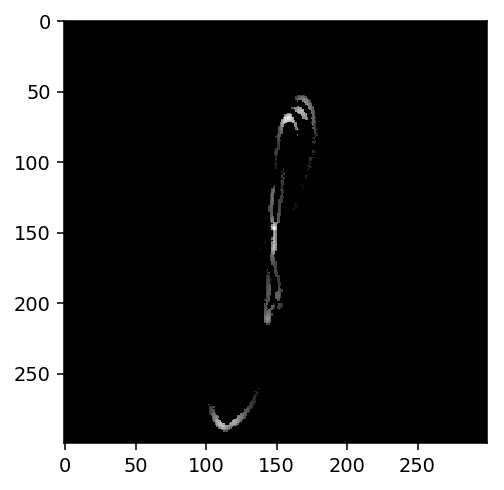

In [16]:
filt = get_concave_map(-im)
plt.imshow(filt*im, vmin=0, vmax=1)
plt.show()

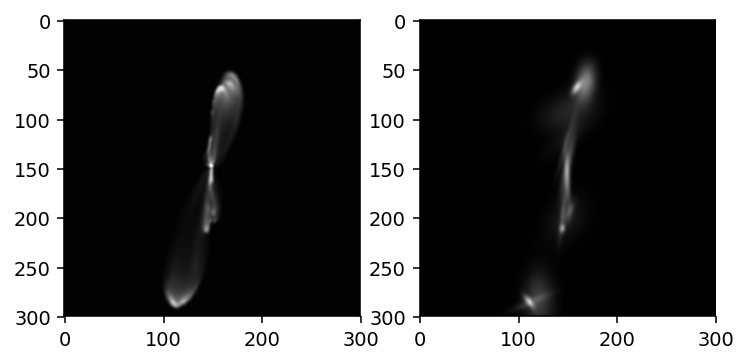

In [25]:
fig, axes = plt.subplots(1,2)
axes[0].imshow(im, vmin=0, vmax=1)
gmm_img = gmm(res.x, mins, im.shape[0])
axes[1].imshow(gmm_img, vmin=0, vmax=1)
plt.show()
# plt.savefig('gmm.png', dpi=192)

In [21]:
print(res)
lg = loss_grad(res.x, mins, im, filt)
print(res.x)
print(lg)
print(loss(res.x, mins, im, filt))
print(loss(res.x-.001*lg, mins, im, filt))

      fun: 72.44798042636019
 hess_inv: <64x64 LbfgsInvHessProduct with dtype=float64>
      jac: array([-1.18398779e-03,  2.15098448e+00, -2.92108521e-03,  4.77251294e-02,
        8.52417701e-04,  1.94930578e+00,  8.15190768e-03,  1.83455587e-02,
       -2.57375438e-04, -3.27310409e-02, -3.72883019e-02,  4.30746036e-02,
        1.28025547e-03,  6.18475716e-01, -3.02046200e-03,  1.54762592e-03,
       -9.05772995e-03,  1.28115077e-01,  5.66358470e-02,  0.00000000e+00,
       -1.72838804e-04,  1.34112061e+00, -1.38790423e-02, -1.73375891e-03,
       -6.27507421e-03,  1.93226174e+00,  1.54928811e-02,  1.50135066e-02,
       -1.08326077e-02,  3.85515887e+00,  3.30742802e-02, -3.92375663e-02,
       -2.09731035e-02,  8.47597223e-01, -1.45654990e-02,  1.53349269e-03,
        7.66442150e-04,  6.93857036e-01,  9.45190253e-03,  4.01917033e-02,
       -2.02538178e-02, -1.14981236e-02,  6.88056855e-04, -2.78275456e-02,
        3.56481021e-01,  9.03738344e-03,  9.44302706e-04,  9.38259686e-04,
  